# Neural Networks

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

t_u.shape

torch.Size([11, 1])

In [4]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 5,  0,  3,  7, 10,  8,  2,  6,  9]), tensor([1, 4]))

In [5]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

## Linear Model

In [6]:
linear_model = nn.Linear(1, 1)
linear_model(t_un_val)

tensor([[4.1145],
        [4.1387]], grad_fn=<AddmmBackward0>)

In [7]:
linear_model.weight

Parameter containing:
tensor([[0.6042]], requires_grad=True)

In [8]:
linear_model.bias

Parameter containing:
tensor([0.7369], requires_grad=True)

In [11]:
x = torch.ones(1)
linear_model(x)

tensor([1.3411], grad_fn=<ViewBackward0>)

In [12]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[1.3411],
        [1.3411],
        [1.3411],
        [1.3411],
        [1.3411],
        [1.3411],
        [1.3411],
        [1.3411],
        [1.3411],
        [1.3411]], grad_fn=<AddmmBackward0>)

In [15]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

In [21]:
linear_model.parameters()

<generator object Module.parameters at 0x7ae4311d4120>

In [22]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.7919]], requires_grad=True),
 Parameter containing:
 tensor([-0.3559], requires_grad=True)]

In [27]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch: {epoch}, Training loss: {loss_train.item():.4f}, Validation loss: {loss_val.item():.4f}")

In [29]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=linear_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch: 1, Training loss: 165.1709, Validation loss: 131.7801
Epoch: 1000, Training loss: 3.4634, Validation loss: 2.7266
Epoch: 2000, Training loss: 2.9853, Validation loss: 2.7311
Epoch: 3000, Training loss: 2.9778, Validation loss: 2.7318

Parameter containing:
tensor([[5.3758]], requires_grad=True)
Parameter containing:
tensor([-17.2738], requires_grad=True)


## Sequential Model

In [30]:
seq_model = nn.Sequential(
    nn.Linear(1, 13),
    nn.Tanh(),
    nn.Linear(13,1)
)

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [33]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [35]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [37]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ("hidden_linear", nn.Linear(1, 8)),
    ("hidden_activation", nn.Tanh()),
    ("output_linear", nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [39]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [40]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.0130], requires_grad=True)

In [42]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val,
)

print("output", seq_model(t_un_val))
print("answer", t_c_val)
print("hidden", seq_model.hidden_linear.weight.grad)

Epoch: 1, Training loss: 1.6038, Validation loss: 3.9497
Epoch: 1000, Training loss: 1.5567, Validation loss: 2.8649
Epoch: 2000, Training loss: 1.5315, Validation loss: 2.9256
Epoch: 3000, Training loss: 1.5154, Validation loss: 2.9744
Epoch: 4000, Training loss: 1.5022, Validation loss: 3.0190
Epoch: 5000, Training loss: 1.4860, Validation loss: 3.0830
output tensor([[11.3487],
        [11.6184]], grad_fn=<AddmmBackward0>)
answer tensor([[14.],
        [11.]])
hidden tensor([[-4.8282],
        [ 0.1630],
        [-4.3242],
        [-0.1198],
        [-0.1392],
        [ 0.0806],
        [ 5.1660],
        [-4.6419]])


## Visualization

In [43]:
import matplotlib.pyplot as plt

In [44]:
t_range = torch.arange(20., 90.).unsqueeze(1)

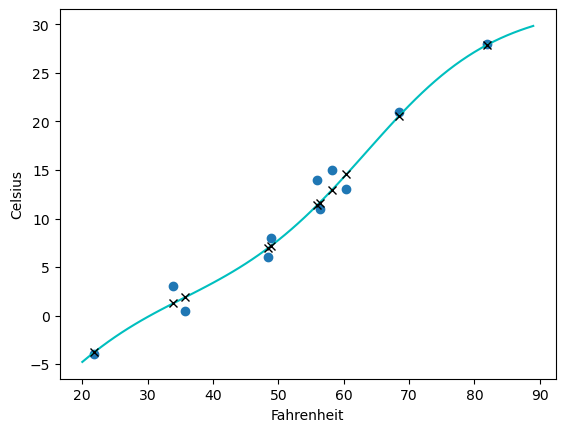

In [45]:
fig = plt.figure()
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), "o")
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), "c-")
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), "kx")
plt.show()